# Probability Modelling in fmdtools
Here we will demonstrate the fmdkit's abilities to find a set of scenarios that represent the effects of a given mode.

In [2]:
#First, import the fault propogation library as well as the model
#since the package is in a parallel location to examples...
import sys
sys.path.append('../')

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import fmdtools.faultprop as fp
import fmdtools.resultproc as rp
from ex_pump import *
from IPython.display import HTML
mdl = Pump()

## Theory and Goals
There are two reasons to run a list of scenarios in fmdkit.
- to determine the expected utility or cost of faults, and
- to determine the relative priority of faults

That is, one would prefer when running scenarios for the expected cost of scenarios to be the same as the expected costs of individual modes:
$C = \sum_{s \in S} P_s*C_s = \sum_{m \in M} \int f_M*C_M$ 


Scenarios have several different aspects:
- which faults are initiated to cause the scenario
- what time the faults are initiated

In general, when one is working with fault models, the assumption is that joint faults are very rare, although work is also being done to incorporate probability models for joint scenarios in this model. However, it may not be clear *when in time* faults should be injected to such that the set of scenarios considered for a fault constitutes the risk from a fault mode.

$C = \sum P_s*C_s $

$C= \sum P_s* \int_{t=t_F}^{t_E} c_s(t) dt$

$C= \sum_m \int_{t=0}^{T_E} f_m(t)* (\int_{t=t_F}^{t_E} c_m(t) dt) dt$
where:
- $P_s$ is the probability of a scenario
- $t$ is time
- $t_F$ is the fault injection time
- $t_E$ is the final modelling time
- $c_s(t)$ is the cost rate of a scenario over time (loss per unit time)
- $m$ is a mode
- $f_m(t)$ is the probability density funciton of a fault mode over the modelled time
- $c_m(t)$ is the cost rate of the scenario resulting from a mode injected

### Solution strategy - take advantage of operational phases
The first thing we might consider about $f_m(t)$ and $c_m(t)$ is in the early design phase is that they both vary depending on the operational phase of the system. That is, we can break the time intervals into phases based on how the system is operating at that time. In the simplest case we might consider an off-state for the system and an on-state for the system, each with different (but constant in the interval) fault rates. To better align with failure data, we might consider a base fault rate for components $r_c$ which is then split between modes with vector $[r_{m_1}, r_{m_2}...r_{m_3}] =  [v_1, v_2...v_3] * r_c$. Then the rates over time are:
$[[r_{m_{1_{t1}}}, r_{m_{2_{t1}}}...r_{m_{w_{t1}}}], [r_{m_{1_{t2}}}, r_{m_{2_{t2}}}...r_{m_{w_{t2}}}] ... [r_{m_{1_{tn}}}, r_{m_{2_{tn}}}...r_{m_{w_{tn}}}]] =  [v_1, v_2...v_3] * r_c * [[s_{m_{1_{t1}}}, s_{m_{2_{t1}}}...s_{m_{w_{t1}}}], [s_{m_{1_{t2}}}, s_{m_{2_{t2}}}...s_{m_{w_{t2}}}] ... [s_{m_{1_{tn}}}, s_{m_{2_{tn}}}...s_{m_{w_{tn}}}]]$

where $r_{m_{j_{ti}}}$ is an individual rate for mode $j$ for a given phase of time $i$. By representing the rate as constant between operational phases. We can now write the above integral as:
$C= \sum_m \sum_{i} r_{m_i} \int_{t=t_i}^{t_{i+1}} (\int_{t=t_F}^{t_E} c_m(t) dt) dt$ where $r_{m_i}$ is the rate for a mode (given above) $t_{i+1}-t_i$ is the time of a given phase, and $t_F$ is a time in the phase $t_{i+1}-t_i$ when the fault is injected. However, estimating the formula still presents a problem. While we could run a simulation at each timestep to get the value of the integral $\int_{t=t_i}^{t_{i+1}} (\int_{t=t_F}^{t_E} c_m(t) dt) dt$, doing so will not be compationally efficient, which is contrary to the point of a model like this. Instead we'd like to be able to run one simulation that is "representative" of the entire phase. In the next few sections I will show a few different sampling strategies to approximate this integral and then run a comparison of each.

### Ideas

- even multi-point sampling (`multi-pt`)

- naive monte carlo (`randtimes` and `arandtimes`)

- symmetric monte carlo (`symrandimes`)

- sample likeliest phase (`maxlike`)


## Model Description
 - pump: fuuctions/flows, phases, faults, etc
 - different utility models:
 - - repair cost
 - - lost water cost
 - - ee use cost
 - - delay / no delay

C:\ProgramData\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


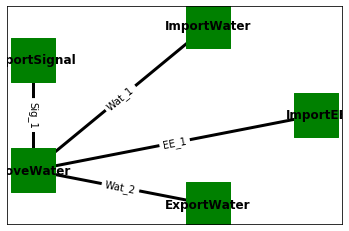

In [3]:
rp.show_graph(mdl.graph)

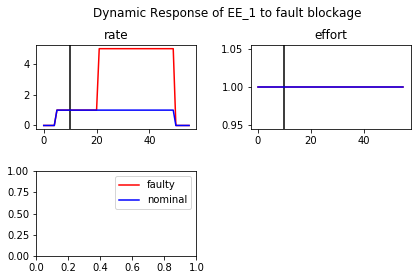

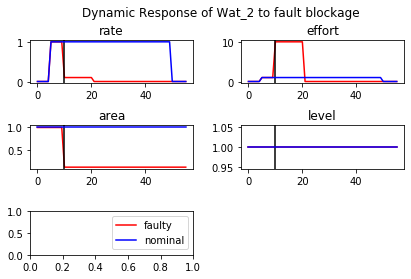

In [4]:
endresults, resgraph, mdlhist=fp.run_one_fault(mdl, 'ExportWater', 'block', time=10, staged=True)
#rp.show_graph(resgraph)
rp.plot_mdlhist(mdlhist, 'blockage', time=10, fxnflows=['Wat_2', 'EE_1'])

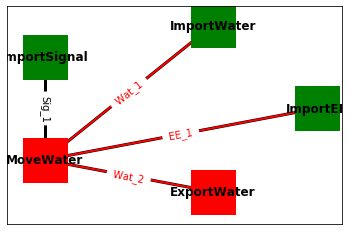

0

In [5]:
reshist,diff1, summary = rp.compare_hist(mdlhist)
rp.plot_resultsgraph_from(mdl, reshist, 45, scale=2.0, gtype='normal')

## Experiments

- Compare percent error and evaulation time for each strategy by sampling strategy/num pts (center, 3, 9) for even sampling, monte carlo, max likelihood, etc
- Compare percent error across cost types (repair, water, ee, full) and show the modes where error is most prevalent
- Find single-point sample that minimizes error with the with the full utility (for maxlike and center point formulations)
- Try to understand uncertainties in rates, costs
- What are the things we know, don't know (things we don't know => uncertainty)

The function below calculates the expected resilience of a model using a given sampling approach

In [6]:
def resilquant(approach, mdl):
    endclasses, mdlhists = fp.run_approach(mdl, approach)
    reshists, diffs, summaries = rp.compare_hists(mdlhists)
    
    fmea = rp.make_summfmea(endclasses, approach)
    fmea2 = rp.make_phasefmea(endclasses, approach)
    util=sum(fmea['expected cost'])
    expdegtimes = rp.make_expdegtimeheatmap(reshists, endclasses)
    return util, expdegtimes, fmea, fmea2

This function calculates error between the full utility and a sampled utility measure.

In [8]:
def calcerror(fullutil, util):    
    return abs((fullutil-util)/fullutil)

Calculating the full integral and likeliest phase estimates:

In [10]:
app_full = SampleApproach(mdl, defaultsamp={'samp':'fullint'})
util_full, expdegtimes_full, fmea_full, phasefmea_full = resilquant(app_full, mdl)

In [12]:
app_maxlike = SampleApproach(mdl, defaultsamp={'samp':'likeliest'})
util_maxlike, expdegtimes_maxlike, fmea_maxlike, phasefmea_maxlike = resilquant(app_maxlike, mdl)

The code below calculates the error of each approach over the number of points used. For the monte-carlo approaches, the results are averaged over 10 simulations and the standard deviation is provided for error bars. The computational cost is also determined by determined by taking the number of simulations needed for each (which is 1 per point (from simulating the nominal) and a fraction based on the injection time of the simulation (faults injected later take less time in simulation)).

In [16]:
possible_pts=[1,3,5,9,15, 30]
samp_types = ['evenspacing', 'randtimes', 'symrandtimes']
errs=dict.fromkeys(samp_types)
errbars=dict.fromkeys(samp_types)
errbar_samps = dict.fromkeys(samp_types)
num_samples = dict.fromkeys(samp_types)
ave_pts=10
for samp_type in samp_types:
    errs[samp_type]=[]
    errbars[samp_type]=[]
    num_samples[samp_type]=[]
    errbar_samps[samp_type] = []
    for pt in possible_pts: #calc errors
        if samp_type in ['randtimes', 'symrandtimes']:
            samperrs=[]
            samps = []
            for ave_pt in range(ave_pts):
                app=SampleApproach(mdl,defaultsamp={'samp':samp_type, 'numpts':pt})
                util, expdegtimes, fmea, phasefmea = resilquant(app, mdl)
                samperrs=samperrs+[calcerror(util_full, util)]
                samps = samps + [len(app.times) + sum([(55-scen['properties']['time'])/55 for scen in app.scenlist])]
            err=np.mean(samperrs)
            errbar=np.std(samperrs)
            num_samps= np.mean(samps)
            errbar_samp = np.std(samps)
        else:
            app=SampleApproach(mdl,defaultsamp={'samp':samp_type, 'numpts':pt})
            util, expdegtimes, fmea, phasefmea = resilquant(app, mdl)
            err = calcerror(util_full, util)
            errbar=0.0
            num_samps = len(app.times) + sum([(55-scen['properties']['time'])/55 for scen in app.scenlist])
            errbar_samp = 0.0
        errs[samp_type]=errs[samp_type]+[err]
        errbars[samp_type]=errbars[samp_type]+[errbar]
        num_samples[samp_type] = num_samples[samp_type] + [num_samps]
        errbar_samps[samp_type] = errbar_samps[samp_type] + [errbar_samp]
    #plt.errorbar(possible_pts, errs[samp_type],yerr=errbars[samp_type], marker='o', label=samp_type)
#plt.legend()
#plt.xlabel("Number of Sample Points")
#plt.yscale("log")
#plt.ylabel("Percent Error")
#plt.title("Error of Sampling Approaches")
#plt.grid('both')

This code makes a nice plot out of those results and calculates computational cost for the full integral and likeliest phase sampling approaches.

Text(0.5, 1.0, 'Error of Sampling Approaches')

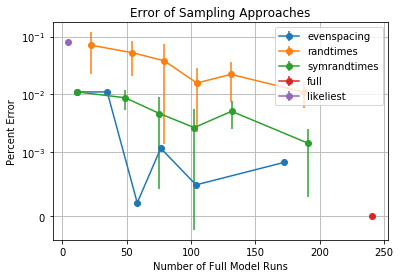

In [17]:
errbar_samps['full'] = [0.0]
errs['full']=[0.0]
errbars['full']=[0.0]
num_samples['full'] = [len(app_full.times) + sum([(55-scen['properties']['time'])/55 for scen in app_full.scenlist])]

errbar_samps['likeliest'] = [0.0]
errs['likeliest']=[calcerror(util_full, util_maxlike)]
errbars['likeliest']=[0.0]
num_samples['likeliest'] = [len(app_maxlike.times) + sum([(55-scen['properties']['time'])/55 for scen in app_maxlike.scenlist])]


for samp in num_samples:
    plt.errorbar(num_samples[samp], errs[samp], yerr=errbars[samp], marker='o', label=samp)
#plt.errorbar(range(len(num_samps)), list(num_samps.values(), )
#plt.xticks(range(len(num_samps)), list(num_samps.keys())
plt.legend(loc='upper right')
plt.xlabel("Number of Full Model Runs")
plt.yscale("symlog", linthreshy=0.001)
plt.grid('both')
plt.ylabel("Percent Error")
plt.title("Error of Sampling Approaches")


So both types of random sampling are dominated by the most probable phase sampling and the multipoint strategy in this case.

#### Error accross model considerations:
Here I compare the error of the center-point strategy accross different model considerations and accross different modes.

In [19]:
#calc resiliences for all appraches
app_center = SampleApproach(mdl)
util_params = [['repair'], ['ee'], ['water'],['repair','ee','water']]
mdl=Pump()
util_center, expdegtimes_center, fmea_center, phasefmea_center = resilquant(app_center, mdl)

error_models={}
error_fmea={}
for util_param in util_params:
    for delay in [[],['delay']]:
        mdl = Pump(params=set(util_param+delay))
        util_center, expdegtimes_center, fmea_center, phasefmea_center = resilquant(app_center, mdl)
        util_full, expdegtimes_full, fmea_full, phasefmea_full = resilquant(app_full, mdl)
        error_models[str(util_param),str(delay)]=calcerror(util_full, util_center)
        error_fmea[str(util_param),str(delay)] = (phasefmea_full['expected cost']-phasefmea_center['expected cost'])/(phasefmea_full['expected cost']+0.001)

In [20]:
rp.make_dicttable(error_models)

['repair']           ['ee']           ['water']            \
             [] ['delay']     [] ['delay']        [] ['delay']   
0  3.235899e-16  0.020257    0.0  0.020024       0.0   0.00056   

  ['repair', 'ee', 'water']            
                         [] ['delay']  
0                       0.0  0.011037

In [21]:
error_fmea_table = pd.concat(error_fmea.values(), axis='columns', keys=error_fmea.keys())

def color_error_red(val):
    if abs(val)>0.01:
        color='red'
    elif val!=0.0:
        color='orange'
    else:
        color='black'
    return 'color: %s' % color
error_fmea_table_stylized = error_fmea_table.style.applymap(color_error_red)
error_fmea_table_stylized

So the error was predominantly introduced by the delay. Thus our main issue for error in the center-point strategy is if there is any resulting timely degradation that may be cut off by the interval (e.g. if the system is turned off before there is damage). In fact, we can imagine the center-point strategy having quite large error if the degradation time becomes roughly the time of the interval.

This may be salient for any model more complicated than this one, especially when there are somewhat sophisticated utility functions, degradation behaviors, or recovery actions.

It should be noted: there is also some error from faults that occur at the edge of a phase, since more or less damage can occur depending on the operational phase. This is the case with the inf_v fault, which doesn't have time to cause damage when the fault is injected, since faults are injected at the end of the next timestep. This is unaviodable without running additional timesteps before or after a fault is injected to 

In [1]:
error_fmea_table.to_latex();

NameError: name 'error_fmea_table' is not defined